In [87]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from random import randint 
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.utils import resample
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn import neighbors

# Load data
Clean it and save the cleaned version.

In [25]:
# calls = pd.read_csv('../data/callsforservicefiltered.csv')
# calls = calls[calls.rptonly != True]
# calls = calls[calls.cancelled != True]
# calls = calls[calls.nature != 'TRANSPORT TO ANIMAL SHELTER']
# calls['calltime'] = pd.to_datetime(calls.calltime)
# calls['year'] = calls.calltime.apply(lambda x: x.date().year)
# calls['month'] = calls.calltime.apply(lambda x: x.date().month)
# calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
# calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
# calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
# calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
# calls = calls.drop(columns = ['statbeat','ra'])
# calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature']!=x['nature2']
#                         else x['nature'] for i,x in calls.iterrows()]
# calls = calls.drop(columns = ['nature','nature2'])
# calls = calls.rename(columns={'actualnature' : 'nature'})

# calls.to_csv('../data/cleaned_callsforservicefiltered.csv', sep='\t', index=False)

Let's split the data into 4 data sets based on the 4 agencies.

In [2]:
filtered_calls = pd.read_csv('../data/cleaned_callsforservicefiltered.csv', sep='\t')
# ems_calls = filtered_calls[filtered_calls.agency == 'EMS']
# aco_calls = filtered_calls[filtered_calls.agency == 'ACO']
# gcsd_calls = filtered_calls[filtered_calls.agency == 'GCSD']
# gcf_calls = filtered_calls[filtered_calls.agency == 'GCF']
print(filtered_calls.columns)

Index(['callsource', 'city', 'priority', 'rptonly', 'service', 'agency',
       'district', 'gp', 'primeunit', 'cancelled', 'closecode', 'dayOfWeek',
       'secs2rt', 'secs2di', 'secs2en', 'secs2ar', 'secs2tr', 'secs2lc',
       'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc', 'secsrt2dsp',
       'secstr2lc', 'firstdisp', 'year', 'month', 'dayOfMonth', 'hour',
       'nature'],
      dtype='object')


## Predict some key natures - classification problem
First, let's see what natures would be predictible; the ones that don't have a call volume uniform distribution in time;
Predicting the nature would be obviously useful when the dispatcher pick up the phone, so no info obtained during the talk can be used.
Only features that are available when dispatcher picks up the phone:
-call source
-city
-district
-gp
-dayOfWeek
-secs2rt
-secs2di (eliminate it, since secsrt2dsp exists)
-secsrt2dsp
-year (eliminate it)
-month
-dayOfMonth (keep only 1 feature day related)
-hour
Then we will eliminate all the features that are not known by the system.

In [3]:
groupby_nature = filtered_calls.groupby(['nature']).size().reset_index(name='count')
groupby_nature.sort_values(by='count', ascending=False, inplace=True)
print(groupby_nature.head(20))

                             nature   count
194                    TRAFFIC STOP  112814
176                     SICK PERSON   68032
104  FALLS-BACK INJURIES(TRAUMATIC)   60599
36               BREATHING PROBLEMS   45883
70                       CHEST PAIN   35518
10    ACCIDENT WITH PERSONAL INJURY   35159
204            UNCONSCIOUS-FAINTING   32938
38                    BURGLAR ALARM   32867
78           CONVALESCENT TRANSPORT   31320
97     EMS RESPONSE - NON EMERGENCY   20779
141         LEGAL PAPER / COMPLAINT   18064
205        UNKNOWN PROBLEM MAN DOWN   17904
175            SEIZURES-CONVULSIONS   17481
57            C22-WARRANT-GCSD ONLY   17215
184             SUSPICIOUS ACTIVITY   17188
186              SUSPICIOUS VEHICLE   16538
43                     C1-FOLLOW UP   15257
128        HEMORRHAGE / LACERATIONS   15245
198         TRANSFER  INTERFACILITY   14990
96         EMS RESPONSE - EMERGENCY   13733


Let's see how the natures are distributed.

In [39]:
def get_nature_month_distribution(data, nature):
    
    data = data[data.nature == nature] 
    data_filtered = data[data.year != 2018]
    data_filtered = data_filtered[data_filtered.year != 2012]    
    groupBy_month = data_filtered.groupby(['month']).size().reset_index(name='count')
    call_distribution = groupBy_month.sort_values(by='month', ascending=True)    
    call_distribution['count'] = call_distribution['count']/12
    return call_distribution

In [40]:
def get_nature_hour_distribution(data, nature):
    
    data = data[data.nature == nature]    
    groupBy_hour = data.groupby(['hour']).size().reset_index(name='count')    
    groupBy_hour['count'] = groupBy_hour['count']/365
    return groupBy_hour

In [41]:
def get_nature_column_distribution(data, nature, column):
    
    data = data[data.nature == nature] 
    groupBy = data.groupby([column]).size().reset_index(name='count')        
    return groupBy

In [42]:
def create_plot(ylabel, title, xlabels, xsizes):
    
    y_pos = np.arange(len(xlabels))    
    plt.bar(y_pos, xsizes, align='center', alpha=1, color="blue")
    plt.xticks(y_pos, xlabels, rotation=0, fontsize = 10)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

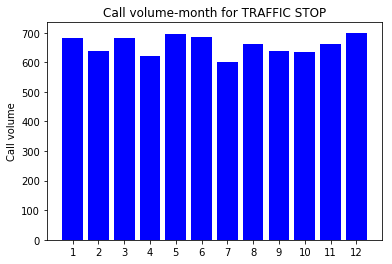

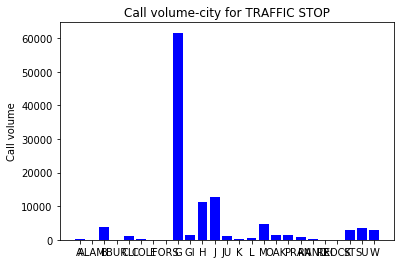

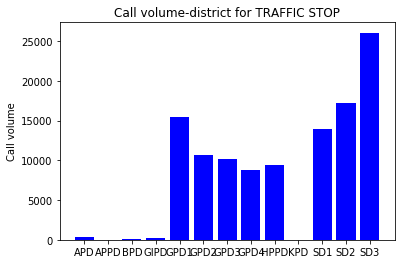

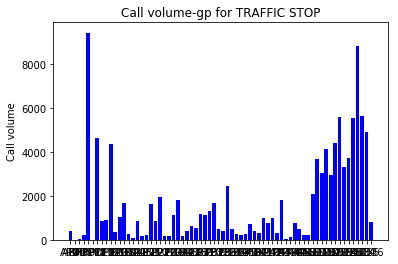

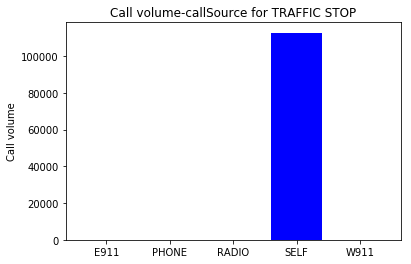

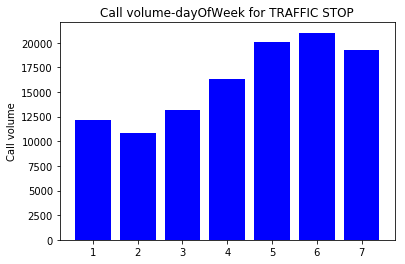

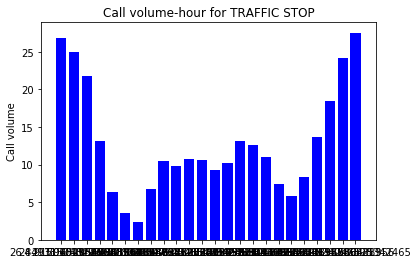

In [12]:
trafficStop_call_distrib = get_nature_month_distribution(filtered_calls, 'TRAFFIC STOP')
months = trafficStop_call_distrib['month']
variance = trafficStop_call_distrib['count']
create_plot('Call volume', 'Call volume-month for TRAFFIC STOP', 
            months, variance)

trafficStop_city_distrib = get_nature_column_distribution(filtered_calls, 'TRAFFIC STOP', 'city')
cities = trafficStop_city_distrib['city']
variance = trafficStop_city_distrib['count']
create_plot('Call volume', 'Call volume-city for TRAFFIC STOP', 
            cities, variance)

trafficStop_district_distrib = get_nature_column_distribution(filtered_calls, 'TRAFFIC STOP', 
                                                              'district')
districts = trafficStop_district_distrib['district']
variance = trafficStop_district_distrib['count']
create_plot('Call volume', 'Call volume-district for TRAFFIC STOP', 
           districts , variance)

trafficStop_gp_distrib = get_nature_column_distribution(filtered_calls, 'TRAFFIC STOP', 
                                                              'gp')
gps = trafficStop_gp_distrib['gp']
variance = trafficStop_gp_distrib['count']
create_plot('Call volume', 'Call volume-gp for TRAFFIC STOP', 
            gps, variance)

trafficStop_callSource_distrib = get_nature_column_distribution(filtered_calls, 'TRAFFIC STOP', 
                                                              'callsource')
sources = trafficStop_callSource_distrib['callsource']
variance = trafficStop_callSource_distrib['count']
create_plot('Call volume', 'Call volume-callSource for TRAFFIC STOP', 
           sources, variance)

trafficStop_dayOfWeek_distrib = get_nature_column_distribution(filtered_calls, 'TRAFFIC STOP', 
                                                              'dayOfWeek')
dayOfWeeks = trafficStop_dayOfWeek_distrib['dayOfWeek']
variance = trafficStop_dayOfWeek_distrib['count']
create_plot('Call volume', 'Call volume-dayOfWeek for TRAFFIC STOP', 
           dayOfWeeks, variance)

trafficStop_hour_distrib = get_nature_hour_distribution(filtered_calls, 'TRAFFIC STOP')
hours = trafficStop_hour_distrib['hour']
variance = trafficStop_hour_distrib['count']
create_plot('Call volume', 'Call volume-hour for TRAFFIC STOP', 
           variance, variance)

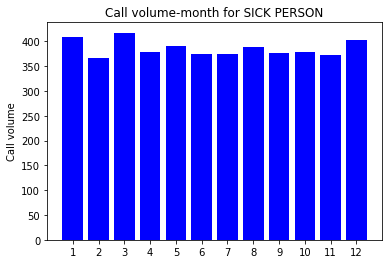

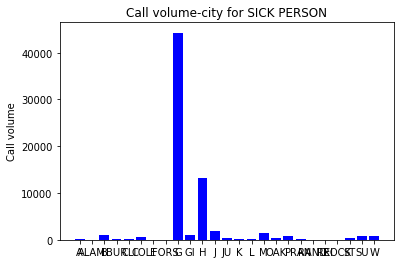

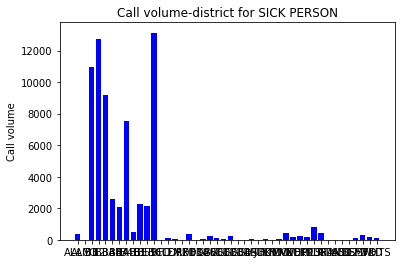

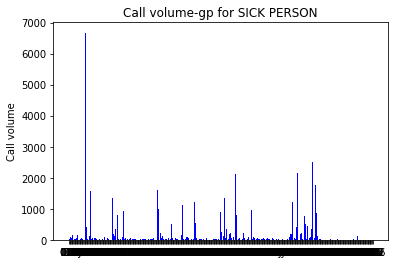

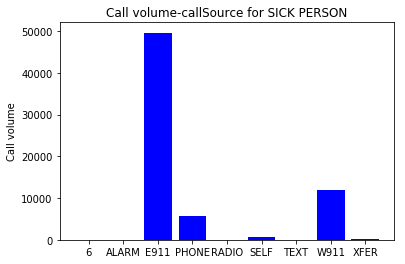

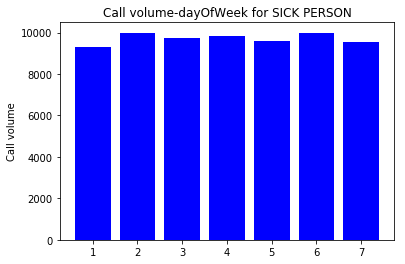

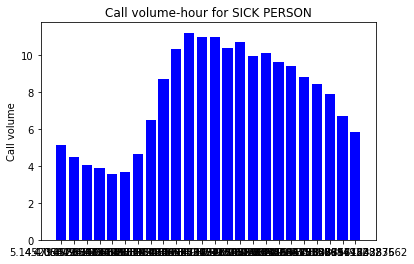

In [15]:
call_distrib = get_nature_month_distribution(filtered_calls, 'SICK PERSON')
months = call_distrib['month']
variance = call_distrib['count']
create_plot('Call volume', 'Call volume-month for SICK PERSON', 
            months, variance)

city_distrib = get_nature_column_distribution(filtered_calls, 'SICK PERSON', 'city')
cities = city_distrib['city']
variance = city_distrib['count']
create_plot('Call volume', 'Call volume-city for SICK PERSON', 
            cities, variance)

district_distrib = get_nature_column_distribution(filtered_calls, 'SICK PERSON', 
                                                              'district')
districts = district_distrib['district']
variance = district_distrib['count']
create_plot('Call volume', 'Call volume-district for SICK PERSON', 
           districts , variance)

gp_distrib = get_nature_column_distribution(filtered_calls, 'SICK PERSON', 
                                                              'gp')
gps = gp_distrib['gp']
variance = gp_distrib['count']
create_plot('Call volume', 'Call volume-gp for SICK PERSON', 
            gps, variance)

callSource_distrib = get_nature_column_distribution(filtered_calls, 'SICK PERSON', 
                                                              'callsource')
sources = callSource_distrib['callsource']
variance = callSource_distrib['count']
create_plot('Call volume', 'Call volume-callSource for SICK PERSON', 
           sources, variance)

dayOfWeek_distrib = get_nature_column_distribution(filtered_calls, 'SICK PERSON', 
                                                              'dayOfWeek')
dayOfWeeks = dayOfWeek_distrib['dayOfWeek']
variance = dayOfWeek_distrib['count']
create_plot('Call volume', 'Call volume-dayOfWeek for SICK PERSON', 
           dayOfWeeks, variance)

hour_distrib = get_nature_hour_distribution(filtered_calls, 'SICK PERSON')
hours = hour_distrib['hour']
variance = hour_distrib['count']
create_plot('Call volume', 'Call volume-hour for SICK PERSON', 
           variance, variance)

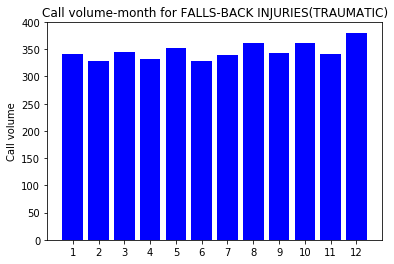

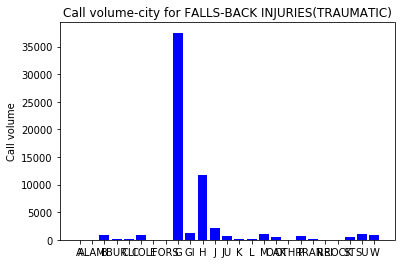

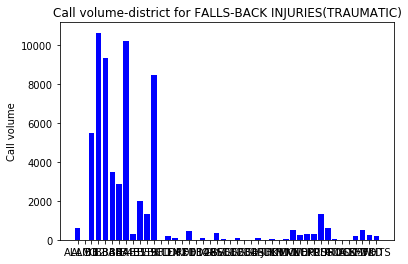

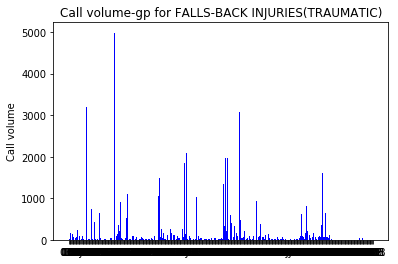

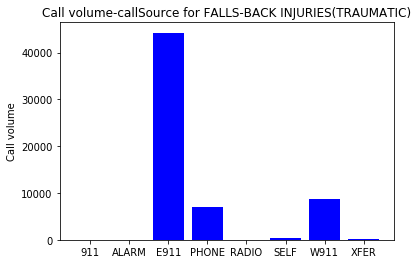

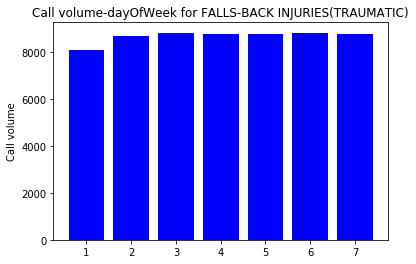

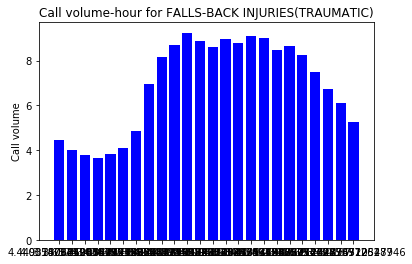

In [13]:
call_distrib = get_nature_month_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)')
months = call_distrib['month']
variance = call_distrib['count']
create_plot('Call volume', 'Call volume-month for FALLS-BACK INJURIES(TRAUMATIC)', 
            months, variance)

city_distrib = get_nature_column_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)', 'city')
cities = city_distrib['city']
variance = city_distrib['count']
create_plot('Call volume', 'Call volume-city for FALLS-BACK INJURIES(TRAUMATIC)', 
            cities, variance)

district_distrib = get_nature_column_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)', 
                                                              'district')
districts = district_distrib['district']
variance = district_distrib['count']
create_plot('Call volume', 'Call volume-district for FALLS-BACK INJURIES(TRAUMATIC)', 
           districts , variance)

gp_distrib = get_nature_column_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)', 
                                                              'gp')
gps = gp_distrib['gp']
variance = gp_distrib['count']
create_plot('Call volume', 'Call volume-gp for FALLS-BACK INJURIES(TRAUMATIC)', 
            gps, variance)

callSource_distrib = get_nature_column_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)', 
                                                              'callsource')
sources = callSource_distrib['callsource']
variance = callSource_distrib['count']
create_plot('Call volume', 'Call volume-callSource for FALLS-BACK INJURIES(TRAUMATIC)', 
           sources, variance)

dayOfWeek_distrib = get_nature_column_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)', 
                                                              'dayOfWeek')
dayOfWeeks = dayOfWeek_distrib['dayOfWeek']
variance = dayOfWeek_distrib['count']
create_plot('Call volume', 'Call volume-dayOfWeek for FALLS-BACK INJURIES(TRAUMATIC)', 
           dayOfWeeks, variance)

hour_distrib = get_nature_hour_distribution(filtered_calls, 'FALLS-BACK INJURIES(TRAUMATIC)')
hours = hour_distrib['hour']
variance = hour_distrib['count']
create_plot('Call volume', 'Call volume-hour for FALLS-BACK INJURIES(TRAUMATIC)', 
           variance, variance)

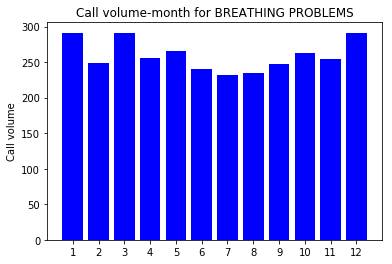

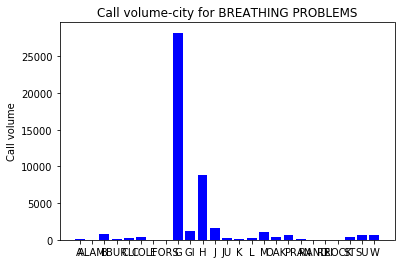

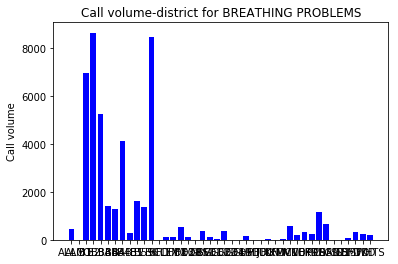

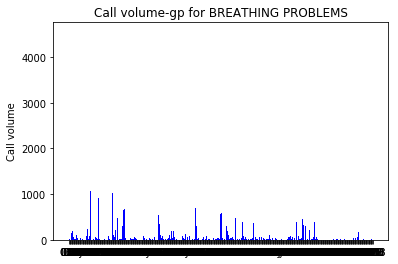

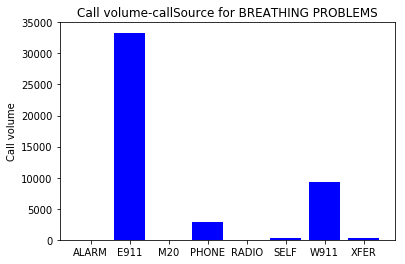

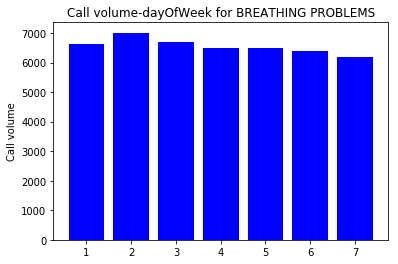

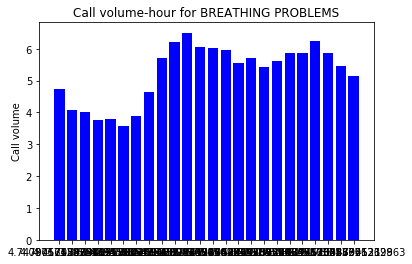

In [16]:
call_distrib = get_nature_month_distribution(filtered_calls, 'BREATHING PROBLEMS')
months = call_distrib['month']
variance = call_distrib['count']
create_plot('Call volume', 'Call volume-month for BREATHING PROBLEMS', 
            months, variance)

city_distrib = get_nature_column_distribution(filtered_calls, 'BREATHING PROBLEMS', 'city')
cities = city_distrib['city']
variance = city_distrib['count']
create_plot('Call volume', 'Call volume-city for BREATHING PROBLEMS', 
            cities, variance)

district_distrib = get_nature_column_distribution(filtered_calls, 'BREATHING PROBLEMS', 
                                                              'district')
districts = district_distrib['district']
variance = district_distrib['count']
create_plot('Call volume', 'Call volume-district for BREATHING PROBLEMS', 
           districts , variance)

gp_distrib = get_nature_column_distribution(filtered_calls, 'BREATHING PROBLEMS', 
                                                              'gp')
gps = gp_distrib['gp']
variance = gp_distrib['count']
create_plot('Call volume', 'Call volume-gp for BREATHING PROBLEMS', 
            gps, variance)

callSource_distrib = get_nature_column_distribution(filtered_calls, 'BREATHING PROBLEMS', 
                                                              'callsource')
sources = callSource_distrib['callsource']
variance = callSource_distrib['count']
create_plot('Call volume', 'Call volume-callSource for BREATHING PROBLEMS', 
           sources, variance)

dayOfWeek_distrib = get_nature_column_distribution(filtered_calls, 'BREATHING PROBLEMS', 
                                                              'dayOfWeek')
dayOfWeeks = dayOfWeek_distrib['dayOfWeek']
variance = dayOfWeek_distrib['count']
create_plot('Call volume', 'Call volume-dayOfWeek for BREATHING PROBLEMS', 
           dayOfWeeks, variance)

hour_distrib = get_nature_hour_distribution(filtered_calls, 'BREATHING PROBLEMS')
hours = hour_distrib['hour']
variance = hour_distrib['count']
create_plot('Call volume', 'Call volume-hour for BREATHING PROBLEMS', 
           variance, variance)

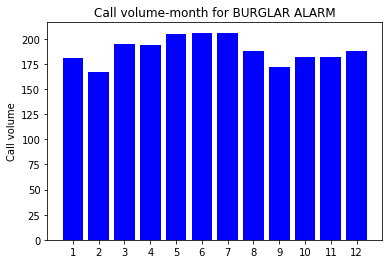

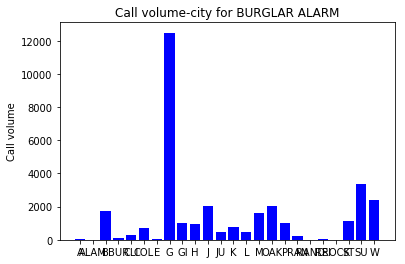

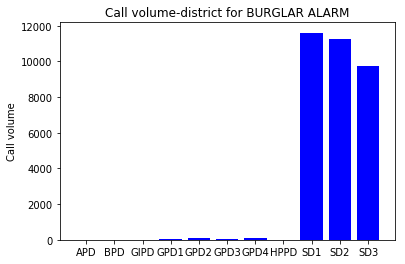

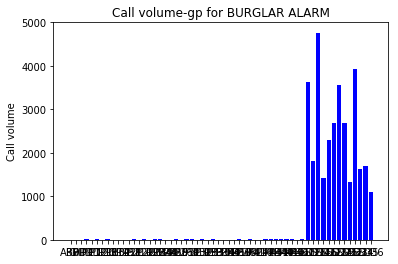

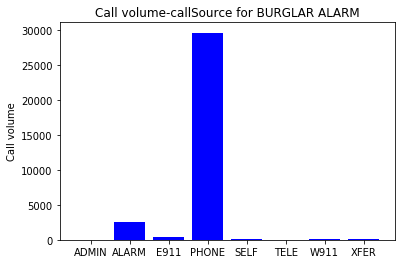

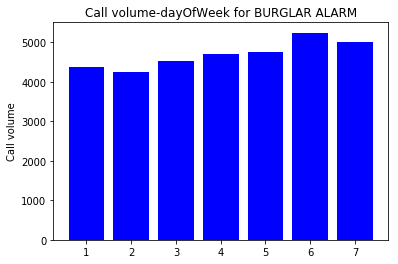

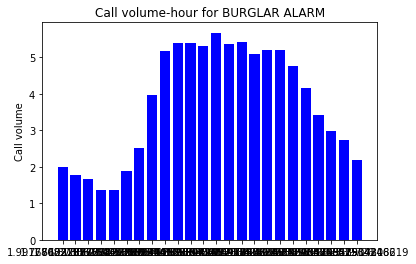

In [44]:
call_distrib = get_nature_month_distribution(filtered_calls, 'BURGLAR ALARM')
months = call_distrib['month']
variance = call_distrib['count']
create_plot('Call volume', 'Call volume-month for BURGLAR ALARM', 
            months, variance)

city_distrib = get_nature_column_distribution(filtered_calls, 'BURGLAR ALARM', 'city')
cities = city_distrib['city']
variance = city_distrib['count']
create_plot('Call volume', 'Call volume-city for BURGLAR ALARM', 
            cities, variance)

district_distrib = get_nature_column_distribution(filtered_calls, 'BURGLAR ALARM', 
                                                              'district')
districts = district_distrib['district']
variance = district_distrib['count']
create_plot('Call volume', 'Call volume-district for BURGLAR ALARM', 
           districts , variance)

gp_distrib = get_nature_column_distribution(filtered_calls, 'BURGLAR ALARM', 
                                                              'gp')
gps = gp_distrib['gp']
variance = gp_distrib['count']
create_plot('Call volume', 'Call volume-gp for BURGLAR ALARM', 
            gps, variance)

callSource_distrib = get_nature_column_distribution(filtered_calls, 'BURGLAR ALARM', 
                                                              'callsource')
sources = callSource_distrib['callsource']
variance = callSource_distrib['count']
create_plot('Call volume', 'Call volume-callSource for BURGLAR ALARM', 
           sources, variance)

dayOfWeek_distrib = get_nature_column_distribution(filtered_calls, 'BURGLAR ALARM', 
                                                              'dayOfWeek')
dayOfWeeks = dayOfWeek_distrib['dayOfWeek']
variance = dayOfWeek_distrib['count']
create_plot('Call volume', 'Call volume-dayOfWeek for BURGLAR ALARM', 
           dayOfWeeks, variance)

hour_distrib = get_nature_hour_distribution(filtered_calls, 'BURGLAR ALARM')
hours = hour_distrib['hour']
variance = hour_distrib['count']
create_plot('Call volume', 'Call volume-hour for BURGLAR ALARM', 
           variance, variance)

## Data Preprocessing
Let's convert all categorical to numerical data. Also, we will apply log transformation on all the numerical data to bring everything into a closer range.

In [4]:
def string_to_numbers(input, column_name):
        
    mapped_list = []
    mapping = dict()    
    for x in input[column_name].unique():
        mapping[x] = randint(1, 1000000)        
    for i in input.index:
        mapped_list.append(mapping[input.at[i, column_name]])
    return mapped_list

In [5]:
filtered_calls['callsource_no'] = string_to_numbers(filtered_calls, 'callsource')
filtered_calls['city_no'] = string_to_numbers(filtered_calls, 'city')
filtered_calls['district_no'] = string_to_numbers(filtered_calls, 'district')
filtered_calls['gp_no'] = string_to_numbers(filtered_calls, 'gp')
filtered_calls['nature_no'] = string_to_numbers(filtered_calls, 'nature')

filtered_calls.replace({'priority': 'P'}, value=10, inplace=True)
filtered_calls.dropna(inplace=True)

filtered_calls.secs2rt = filtered_calls.secs2rt.apply(np.log)
filtered_calls.secs2di = filtered_calls.secs2di.apply(np.log)
filtered_calls.secs2en = filtered_calls.secs2en.apply(np.log)
filtered_calls.secs2ar = filtered_calls.secs2ar.apply(np.log)
filtered_calls.secs2tr = filtered_calls.secs2tr.apply(np.log)
filtered_calls.secs2lc = filtered_calls.secs2lc.apply(np.log)
filtered_calls.secsdi2en = filtered_calls.secsdi2en.apply(np.log)
filtered_calls.secsdi2ar = filtered_calls.secsdi2ar.apply(np.log)
filtered_calls.secsar2tr = filtered_calls.secsar2tr.apply(np.log)
filtered_calls.secsar2lc = filtered_calls.secsar2lc.apply(np.log)
filtered_calls.secsrt2dsp = filtered_calls.secsrt2dsp.apply(np.log)
filtered_calls.secstr2lc = filtered_calls.secstr2lc.apply(np.log)
filtered_calls.replace([np.inf, -np.inf], 0, inplace=True)

Extract phone calls related to first 4 most popular natures.

In [6]:
trafficStop = filtered_calls[filtered_calls.nature == 'TRAFFIC STOP']
trafficStop.drop(columns=['callsource', 'city', 'district', 'gp', 'nature'], 
                             inplace=True)
sickPerson = filtered_calls[filtered_calls.nature == 'SICK PERSON']
sickPerson.drop(columns=['callsource', 'city', 'district', 'gp', 'nature'], 
                             inplace=True)
fallBack = filtered_calls[filtered_calls.nature == 'FALLS-BACK INJURIES(TRAUMATIC)']
fallBack.drop(columns=['callsource', 'city', 'district', 'gp', 'nature'], 
                             inplace=True)
breathingPb = filtered_calls[filtered_calls.nature == 'BREATHING PROBLEMS']
breathingPb.drop(columns=['callsource', 'city', 'district', 'gp', 'nature'], 
                             inplace=True)

/home/oana/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Let's downsample the categories

In [9]:
trafficStop_downs = resample(trafficStop, replace=False, n_samples=45883, random_state=123)
sickPerson_downs = resample(sickPerson, replace=False, n_samples=45883, random_state=123)
fallBack_downs = resample(fallBack, replace=False, n_samples=45883, random_state=123)
breathingPb_downs = resample(breathingPb, replace=True, n_samples=45883, random_state=123)
revised_data_downsample = pd.concat([trafficStop_downs, sickPerson_downs, 
                                     fallBack_downs, breathingPb_downs], ignore_index=True)
print(len(revised_data_downsample))
revised_data_downsample.drop(columns=['priority', 'rptonly', 'service', 'agency',
       'primeunit', 'cancelled', 'closecode',
       'secs2di', 'secs2en', 'secs2ar', 'secs2tr', 'secs2lc',
       'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secstr2lc', 'firstdisp', 'year'], inplace=True)

183532


Let's upsample the categories

In [10]:
trafficStop_ups = resample(trafficStop, replace=False, n_samples=60000, random_state=123)
sickPerson_ups = resample(sickPerson, replace=False, n_samples=60000, random_state=123)
fallBack_ups = resample(fallBack, replace=False, n_samples=60000, random_state=123)
breathingPb_ups = resample(breathingPb, replace=True, n_samples=60000, random_state=123)
revised_data_upsample = pd.concat([trafficStop_ups, sickPerson_ups, fallBack_ups, 
                                   breathingPb_ups], ignore_index=True)
print(len(revised_data_upsample))
revised_data_upsample.drop(columns=['priority', 'rptonly', 'service', 'agency',
       'primeunit', 'cancelled', 'closecode',
       'secs2di', 'secs2en', 'secs2ar', 'secs2tr', 'secs2lc',
       'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secstr2lc', 'firstdisp', 'year'], inplace=True)

240000


Let's see the correlation between the features and drop any if necessary.

In [41]:
revised_data_downsample.corr()

,dayOfWeek,secs2rt,secsrt2dsp,month,dayOfMonth,hour,callsource_no,city_no,district_no,gp_no
dayOfWeek,1.000000,-0.046214,-0.006365,-0.005156,0.002361,-0.000738,0.066994,-0.002926,0.026691,-0.012966
secs2rt,-0.046214,1.000000,0.128069,-0.001747,-0.006113,0.031573,-0.294671,0.049596,-0.132124,0.124220
secsrt2dsp,-0.006365,0.128069,1.000000,-0.015800,-0.007891,0.036155,-0.117734,0.014120,-0.045412,0.031776
month,-0.005156,-0.001747,-0.015800,1.000000,0.023845,0.001430,0.001139,0.001724,0.003356,0.003059
dayOfMonth,0.002361,-0.006113,-0.007891,0.023845,1.000000,0.002680,0.007380,-0.005097,0.001921,-0.002384
hour,-0.000738,0.031573,0.036155,0.001430,0.002680,1.000000,-0.027396,-0.027247,-0.004983,-0.002953
callsource_no,0.066994,-0.294671,-0.117734,0.001139,0.007380,-0.027396,1.000000,-0.122721,0.195133,-0.073986
city_no,-0.002926,0.049596,0.014120,0.001724,-0.005097,-0.027247,-0.122721,1.000000,0.070631,-0.051198
district_no,0.026691,-0.132124,-0.045412,0.003356,0.001921,-0.004983,0.195133,0.070631,1.000000,-0.162160
gp_no,-0.012966,0.124220,0.031776,0.003059,-0.002384,-0.002953,-0.073986,-0.051198,-0.162160,1.000000


Let's try out RandomForestClasiffier on both upsampled and downsampled data and see what we get.

In [19]:
targets = revised_data_downsample.nature_no
# targets[:, np.newaxis]
features = revised_data_downsample.drop(columns=['nature_no'])
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123, n_jobs=2)
results_cv = model_selection.cross_val_score(model, features, targets, cv=kfold,
                                                     scoring='precision_weighted')  
print('Mean precision with default model params '+str(results_cv.mean()))

# model.fit(X_train, y_train)
# preds = model.predict(X_test)
# print('Accuracy for upsampling '+str(accuracy_score(y_test, preds)))
# print(model.score(X_test, y_test))
# print(model.score(X_train, y_train))

Mean precision with default model params 0.6526244941127921


In [55]:
targets = revised_data_upsample.nature_no
targets[:, np.newaxis]
features = revised_data_upsample.drop(columns=['nature_no'])
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123, n_jobs=2)
results_cv = model_selection.cross_val_score(model, features, targets, cv=kfold,
                                                     scoring='precision_weighted')  
print('Mean precision with default model params '+str(results_cv.mean()))

# model.fit(X_train, y_train)
# preds = model.predict(X_test)
# print(model.get_params())
# print(model.score(X_test, y_test))
# print(model.score(X_train, y_train))

Mean precision with default model params 0.6720014050433271


When we did upsampling, the R sq went up, which indicates that the breathing pb category was underrepresented.
Let's see the confusion matrix.

In [59]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, targets, 
                                        test_size=0.2, random_state=123, shuffle=True)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(len(y_test))

[[ 9219  1494  1223     1]
 [ 2778  5760  3493    12]
 [ 2666  4126  5199     7]
 [    3     3     3 12013]]
48000


Let's try to tune the model to obtain better predictions.

In [61]:
targets_tunining = revised_data_upsample.nature_no
features_tuning = revised_data_upsample.drop(columns=['nature_no'])
print(features_tuning.shape)
print(targets_tunining.shape)
n_trees = [1, 10, 25, 50, 100]
scoring = 'accuracy'
for trees in n_trees:     
    kfold = model_selection.KFold(n_splits=10, shuffle = True, random_state=7)
    model_tune = RandomForestClassifier(n_estimators=trees, random_state=7, n_jobs=-1)
    results_cv = model_selection.cross_val_score(model_tune, features_tuning, 
                                                 targets_tunining, cv=kfold,
                                                 scoring=scoring)                       
    print('For model n_trees '+str(trees)+', accuracy mean is '+str(results_cv.mean()))

(240000, 10)
(240000,)
For model n_trees 1, accuracy mean is 0.6239916666666667
For model n_trees 10, accuracy mean is 0.6789541666666666
For model n_trees 25, accuracy mean is 0.6961958333333332
For model n_trees 50, accuracy mean is 0.7038958333333334
For model n_trees 100, accuracy mean is 0.7079333333333333


Let's try it out for onyl 2 natures and see what we get.

In [62]:
trafficStop_2cat = resample(trafficStop, replace=False, n_samples=70000, random_state=123)
sickPerson_2cat = resample(sickPerson, replace=True, n_samples=70000, random_state=123)
data_2Cat = pd.concat([trafficStop_2cat, sickPerson_2cat], ignore_index=True)
data_2Cat.drop(columns=['priority', 'rptonly', 'service', 'agency',
       'primeunit', 'cancelled', 'closecode',
       'secs2di', 'secs2en', 'secs2ar', 'secs2tr', 'secs2lc',
       'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secstr2lc', 'firstdisp', 'year'], inplace=True)

In [67]:
targets_2cat = data_2Cat.nature_no
# targets[:, np.newaxis]
features_2cat = data_2Cat.drop(columns=['nature_no'])
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
model = RandomForestClassifier(random_state=123, n_jobs=2)
results_cv = model_selection.cross_val_score(model, features_2cat, targets_2cat, cv=kfold,
                                                     scoring='precision_weighted')  
print('Mean precision with default model params '+str(results_cv.mean()))

Mean precision with default model params 0.9994716284058995


## Logistic regression to predict the natures.

In [78]:
targets_LogisR = revised_data_upsample.nature_no
features_LogisR = revised_data_upsample.drop(columns=['nature_no'])
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
clf = LogisticRegression(penalty='l2')
results_cv = model_selection.cross_val_score(clf, features_LogisR, targets_LogisR, cv=kfold,
                                                     scoring='precision_weighted')  
print('Mean precision with default model params '+str(results_cv.mean()))

Mean precision with default model params 0.3625665421821438


In [79]:
targets_LogisR = label_binarize(targets_LogisR, classes=[729032, 286123, 711833, 150302])
n_classes = targets_LogisR.shape[1]
X_train, X_test, y_train, y_test = model_selection.train_test_split(features_LogisR, 
                                                                    targets_LogisR, 
                                                            test_size=0.2, random_state=0)

random_state = np.random.RandomState(0)
classifier = OneVsRestClassifier(LogisticRegression())
fit_model = classifier.fit(X_train, y_train)
y_score = fit_model.decision_function(X_test)
y_pred = fit_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.72      0.36      0.48     12055
          1       0.00      0.00      0.00     11904
          2       0.00      0.00      0.00     11885
          3       0.00      0.00      0.00     12156

avg / total       0.18      0.09      0.12     48000



/home/oana/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [89]:
targets_knn = revised_data_upsample.nature_no
features_knn = revised_data_upsample.drop(columns=['nature_no'])
kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=123)
no_neighbors = [1, 5, 7]
for neigh in no_neighbors:
    clasif = neighbors.KNeighborsClassifier(n_neighbors=neigh)
    results_cv = model_selection.cross_val_score(clasif, features_knn, targets_knn, cv=kfold,
                                                         scoring='precision_weighted')  
    print('Number neighbors '+str(neigh)+', Mean precision with default model params '+\
          str(results_cv.mean()))

Number neighbors 1, Mean precision with default model params 0.6504592879434345
Number neighbors 5, Mean precision with default model params 0.5929483127991834
Number neighbors 7, Mean precision with default model params 0.586730251829555
